In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from time import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option('display.max.columns', None)

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('Home_Loan/application_train.csv.tar.gz')

In [4]:
mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()

def clean_data(df, test=True):
    global mm_scaler, std_scaler
    
    # Drop rows where target value is missing
    df.dropna(subset=["TARGET"], inplace=True)
    
    # Drop rows where important monetary values are missing
    df.dropna(subset=["AMT_INCOME_TOTAL", "AMT_CREDIT",
                      "AMT_ANNUITY", "AMT_GOODS_PRICE"],
              inplace=True)
    
    # Drop outliers
    if not test:
        idx = np.all(stats.zscore(df[["AMT_INCOME_TOTAL", "AMT_CREDIT",
                                      "AMT_ANNUITY", "AMT_GOODS_PRICE"]]) < 3, axis=1)
        df = df[idx]
    
    # Drop outlier from "DAYS_EMPLOYED" that are not caught by zscore
    df.drop(index=df[df["DAYS_EMPLOYED"] >= df["DAYS_EMPLOYED"].quantile(0.99)].index, inplace=True)
    
    # Create list y with target values
    y = df["TARGET"].astype("int").astype("category")
    
    # Create DataFrame X for all features
    X = pd.DataFrame()
    
    # Copy already correct columns
    X["REGION_POPULATION_RELATIVE"] = df["REGION_POPULATION_RELATIVE"]
    
    # Convert data types
    X["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].replace(["Y", "N"], [1, 0]).astype("int").astype("category")
    X["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].replace(["Y", "N"], [1, 0]).astype("int").astype("category")
    X["REG_REGION_NOT_LIVE_REGION"] = df["REG_REGION_NOT_LIVE_REGION"].astype("int").astype("category")
    X["REG_REGION_NOT_WORK_REGION"] = df["REG_REGION_NOT_WORK_REGION"].astype("int").astype("category")
    X["LIVE_REGION_NOT_WORK_REGION"] = df["LIVE_REGION_NOT_WORK_REGION"].astype("int").astype("category")
    X["REG_CITY_NOT_LIVE_CITY"] = df["REG_CITY_NOT_LIVE_CITY"].astype("int").astype("category")
    X["REG_CITY_NOT_WORK_CITY"] = df["REG_CITY_NOT_WORK_CITY"].astype("int").astype("category")
    
    # Create dummy variables for categorical columns
    X = pd.concat([X, pd.get_dummies(df[["NAME_CONTRACT_TYPE", "CODE_GENDER", "NAME_TYPE_SUITE",
                                         "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
                                         "NAME_HOUSING_TYPE", "ORGANIZATION_TYPE"]],
                                     drop_first=True)], 1)
        
    # Use Scaler
    if test:
        X[["CNT_CHILDREN"]] = mm_scaler.transform(df[["CNT_CHILDREN"]])
        X[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]] = std_scaler.transform(df[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]])
        X[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]] = mm_scaler.transform(df[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]] * -1)
    else:
        X[["CNT_CHILDREN"]] = mm_scaler.fit_transform(df[["CNT_CHILDREN"]])
        X[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]] = std_scaler.fit_transform(df[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]])
        X[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]] = mm_scaler.fit_transform(df[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]] * -1)
    
    # Filling all NaNs with mean values
    col_names = df.loc[:, "EXT_SOURCE_1" : "NONLIVINGAREA_MEDI"].columns
    X[col_names] = df[col_names].fillna(value=df[col_names].mean())
    X["TOTALAREA_MODE"] = df["TOTALAREA_MODE"].fillna(value=df["TOTALAREA_MODE"].mean())
    
    return X, y

In [5]:
# preparing X and y for the split
X, y = clean_data(data, test=False)

In [6]:
# splitting the data with stratifying due imbalanced data
from sklearn.model_selection import train_test_split

RSEED = 50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state = RSEED)

In [7]:
# importing Regression models and evaluation matrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, accuracy_score

In [17]:
# Fucntion for training different models

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 1000 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:1000])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 1000 training samples
    results['acc_train'] = accuracy_score(y_train[:1000],predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 1000 training samples
    results['f_train'] = fbeta_score(y_train[:1000],predictions_train,beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
    
    # Compute precision_score on the the first 1000 training samples
    results['Precision_train'] = precision_score(y_train[:1000],predictions_train)
    
    # Compute precision_score on the test set
    results['Precision_test'] = precision_score(y_test,predictions_test)
    
    # Compute recall_score on the the first 1000 training samples
    results['Recall_train'] = recall_score(y_train[:1000],predictions_train)
    
    # Compute recall_score on the test set
    results['Recall_test'] = recall_score(y_test,predictions_test)
    
    # Compute roc_auc_score on the first 1000 training samples
    results['Roc_Auc_Score_train'] = roc_auc_score(y_train[:1000],predictions_train)
    
    # Compute roc_auc_score on the test set
    results['Roc_Auc_Score_test'] = roc_auc_score(y_test,predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [18]:
# TODO: Initialize the three models, the random states are set to 50 so we know how to reproduce the model later

clf_A = LogisticRegression(class_weight='balanced',random_state=RSEED)
clf_B = DecisionTreeClassifier(random_state=RSEED)
clf_C = RandomForestClassifier(n_estimators=500, 
                               random_state=RSEED, 
                               max_features = 'sqrt',  
                               n_jobs=-1, verbose = 1)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 1721 samples.
LogisticRegression trained on 17208 samples.
LogisticRegression trained on 172084 samples.
DecisionTreeClassifier trained on 1721 samples.
DecisionTreeClassifier trained on 17208 samples.
DecisionTreeClassifier trained on 172084 samples.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finis

RandomForestClassifier trained on 1721 samples.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finis

RandomForestClassifier trained on 17208 samples.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.7s


RandomForestClassifier trained on 172084 samples.


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished


In [19]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
train_time,0.054059,0.314780,3.312411
pred_time,0.061810,0.061907,0.067762
acc_train,0.731000,0.660000,0.672000
acc_test,0.696194,0.675882,0.682621
f_train,0.254613,0.202240,0.216845
f_test,0.189060,0.193145,0.198863
Precision_train,0.218354,0.171504,0.184000
Precision_test,0.161641,0.164149,0.169148
Recall_train,0.758242,0.714286,0.758242
Recall_test,0.588072,0.658220,0.668881


DecisionTreeClassifier


,1%,10%,100%
train_time,0.063970,0.787731,11.432905
pred_time,0.062436,0.092708,0.088781
acc_train,1.000000,1.000000,1.000000
acc_test,0.841534,0.840328,0.844626
f_train,1.000000,1.000000,1.000000
f_test,0.134293,0.140538,0.158492
Precision_train,1.000000,1.000000,1.000000
Precision_test,0.131969,0.137309,0.155165
Recall_train,1.000000,1.000000,1.000000
Recall_test,0.144468,0.155130,0.173362


RandomForestClassifier


,1%,10%,100%
train_time,0.804389,4.718681,83.660511
pred_time,0.887442,1.682888,3.238292
acc_train,1.000000,1.000000,1.000000
acc_test,0.912259,0.912299,0.912367
f_train,1.000000,1.000000,1.000000
f_test,0.009141,0.003083,0.012188
Precision_train,1.000000,1.000000,1.000000
Precision_test,0.521739,1.000000,0.695652
Recall_train,1.000000,1.000000,1.000000
Recall_test,0.001854,0.000618,0.002472


In [21]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

# Fit 
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:  9.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                     

In [22]:
rs.best_params_

{'n_estimators': 87,
 'min_samples_split': 10,
 'max_leaf_nodes': 28,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

## Use Best Model

Now we can take the best model (it has already been trained) and evaluate it. Hopefully it does better than the stock Random Forest.

In [23]:
best_model = rs.best_estimator_

In [24]:
train_rf_predictions = best_model.predict(X_train)
train_rf_probs = best_model.predict_proba(X_train)[:, 1]

test_rf_predictions = best_model.predict(X_test)
test_rf_probs = best_model.predict_proba(X_test)[:, 1]

In [29]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.09 Test: 0.0 Train: 0.0
Roc Baseline: 0.5 Test: 0.72 Train: 0.74


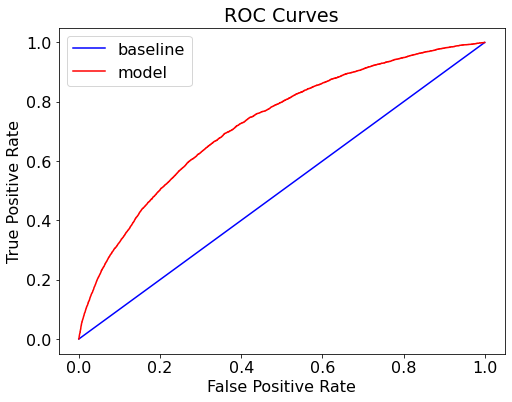

In [30]:
evaluate_model(test_rf_predictions, test_rf_probs, train_rf_predictions, train_rf_probs)

In [31]:
print(classification_report(y_test, test_rf_predictions))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     67279
           1       0.00      0.00      0.00      6472

    accuracy                           0.91     73751
   macro avg       0.46      0.50      0.48     73751
weighted avg       0.83      0.91      0.87     73751

